# Homework 3

## References

-   Lectures 8-12 (inclusive).

## Instructions

-   Type your name and email in the "Student details" section below.
-   Develop the code and generate the figures you need to solve the problems using this notebook.
-   For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before, and you find it exceedingly difficult, we will likely accept handwritten solutions.
-   The total homework points are 100. Please note that the problems are not weighed equally.


In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
%matplotlib inline
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import numpy as np
from numpy.typing import NDArray
import pandas as pd
from typing import Callable

## Student details

-   **First Name:** Matthew
-   **Last Name:** Hansen
-   **Email:** hanse217@purdue.edu


## Problem 1 - Propagating uncertainty through a differential equation

This is a classic uncertainty propagation problem you must solve using Monte Carlo sampling.
Consider the following stochastic harmonic oscillator:

$$
\begin{array}{ccc}
\ddot{y} + 2 \zeta \omega(X) \dot{y} + \omega^2(X)y &=& 0,\\
y(0) &=& y_0(X),\\
\dot{y}(0) &=& v_0(X),
\end{array}
$$

where:

-   $X = (X_1, X_2, X_3)$,
-   $X_i \sim N(0, 1)$,
-   $\omega(X) = 2\pi + X_1$,
-   $\zeta = 0.01$,
-   $y_0(X) = 1+ 0.1 X_2$, and
-   $v_0 = 0.1 X_3$.

In other words, this stochastic harmonic oscillator has an uncertain natural frequency and uncertain initial conditions.

Our goal is to propagate uncertainty through this dynamical system, i.e., estimate the mean and variance of its solution.
A solver for this dynamical system is given below:


In [2]:
class Solver:
    def __init__(self, n_time_steps: int = 100, t_max: float = 5):
        self.n_time_steps = n_time_steps
        self.t_max = t_max
        self.t = np.linspace(0, t_max, n_time_steps)
        self.num_inputs = 3
        self.num_outputs = n_time_steps

    def __call__(self, x: NDArray) -> NDArray:
        # ODE parameters
        omega = 2 * np.pi + x[0]
        y10 = 1 + 0.1 * x[1]
        y20 = 0.1 * x[2]

        # initial conditions
        y0 = np.array([y10, y20])

        # coefficient matrix
        zeta = 0.01
        # spring constant
        k = omega ** 2
        # damping coeff
        c = 2 * zeta * omega
        C = np.array([[0, 1], [-k, -c]])

        # RHS of the ODE system
        def rhs(y, t):
            return np.dot(C, y)

        return scipy.integrate.odeint(rhs, y0, self.t)

In [3]:
solver = Solver()

x = np.random.randn(solver.num_inputs)

y = solver(x)
# print(y)

Let's plot a few samples:


In [4]:
# Some constants to create uniform figure sizes and axis labels
DUAL_PLOT_SIZE = (7.5, 4)

TIME_LABEL = r"$t$ (Time, $s$)"
POS_LABEL = r"$y(t)$ (Position, $m$)"
POS2_LABEL = r"$y^2(t)$ (Position Squared, $m^2$)"
VEL_LABEL = r"$\dot{y}(t)$ (Velocity, $m/s$)"
VEL2_LABEL = (r"$\dot{y}^2(t)$ "
              r"(Velocity Squared, $m^2/s^2$)")
N_LABEL = r"$N$ (Number of samples)"
MEAN_POS_LABEL = (r"$\bar{I}_{N,y}$ "
                  r"(Mean Position, $m$)")
MEAN_POS2_LABEL = (r"$\bar{I}_{N,y^2}$ "
                   r"(Mean Position Squared, $m^2$)")
MEAN_VEL_LABEL = (r"$\bar{I}_{N,\dot{y}}$ "
                  r"(Mean Velocity, $m/s$)")
MEAN_VEL2_LABEL = (r"$\bar{I}_{N,\dot{y}^2}$ "
                   r"(Mean Velocity Squared, $m^2/s^2$)")

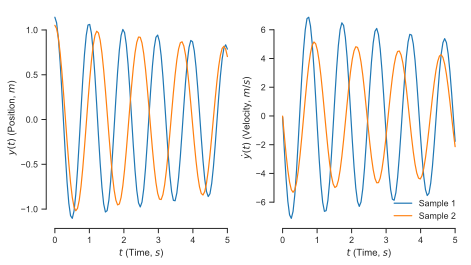

In [5]:
_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE, sharex=True)

axs[0].set_xlabel(TIME_LABEL)
axs[0].set_ylabel(POS_LABEL)

axs[1].set_xlabel(TIME_LABEL)
axs[1].set_ylabel(VEL_LABEL)

for i in range(2):
    x = np.random.randn(solver.num_inputs)
    y = solver(x)

    axs[0].plot(solver.t, y[:, 0])
    axs[1].plot(solver.t, y[:, 1], label=f"Sample {i + 1:d}")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True)

For your convenience, here is code that takes many samples of the solver at once:

In [6]:
def sample_from_solver(N: int) -> NDArray:
    samples = np.ndarray([N, 100, 2])
    for i in range(N):
        samples[i, :, :] = solver(np.random.randn(solver.num_inputs))
    return samples

### Part A

Take 100 samples of the solver output and plot the estimated mean position and velocity as a function of time along with a 95\% epistemic uncertainty interval around it.
This interval captures how sure you are about the mean response when using only 100 Monte Carlo samples.
You need to use the central limit theorem to find it (see the lecture notes).


In [7]:
N = 100
samples_posterior_predictive = sample_from_solver(N)
pos_samples = samples_posterior_predictive[:, :, 0]
vel_samples = samples_posterior_predictive[:, :, 1]

In [8]:
def plot_confidence_all_time_steps(
    ax: Axes, x: NDArray[float], y: NDArray[float], legend: bool = False
):
    confidence = 0.95
    a = 1 - confidence
    q025 = np.quantile(y, a / 2, axis=0)
    q975 = np.quantile(y, 1 - a / 2, axis=0)
    mu = np.mean(y, axis=0)
    ax.fill_between(x, q025, q975, alpha=0.3, label=f"{confidence:.0%} CI")
    ax.plot(x, mu, label="mean")
    if legend:
        ax.legend(frameon=False)

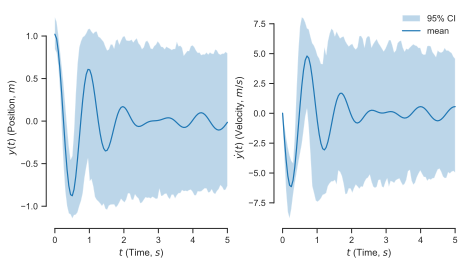

In [9]:
_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE, sharex=True)

axs[0].set_xlabel(TIME_LABEL)
axs[0].set_ylabel(POS_LABEL)

axs[1].set_xlabel(TIME_LABEL)
axs[1].set_ylabel(VEL_LABEL)

plot_confidence_all_time_steps(axs[0], solver.t, pos_samples)
plot_confidence_all_time_steps(axs[1], solver.t, vel_samples, legend=True)
sns.despine(trim=True)

### Part B

Plot the epistemic uncertainty about the mean position at $t=5$ s as a function of the number of samples.

**Solution**:


In [10]:
def get_mean_and_var(y: NDArray) -> tuple[NDArray, NDArray]:
    assert y.ndim == 1
    I_running = np.cumsum(y) / np.arange(1, N + 1)
    I2_running = np.cumsum(y ** 2) / np.arange(1, N + 1)
    sigma2_running = I2_running - I_running ** 2
    return I_running, sigma2_running


def plot_confidence_at_point(
    ax: Axes,
    I: NDArray,
    sigma2: NDArray,
    legend: bool = False
):
    z_95ish = 2
    I_low = I - z_95ish * np.sqrt(sigma2 / np.arange(1, N + 1))
    I_high = I + z_95ish * np.sqrt(sigma2 / np.arange(1, N + 1))
    ax.fill_between(np.arange(1, N + 1), I_low, I_high, alpha=0.3,
                    label="~95% CI")
    ax.plot(np.arange(1, N + 1), I, label="mean")
    if legend:
        ax.legend(frameon=False)

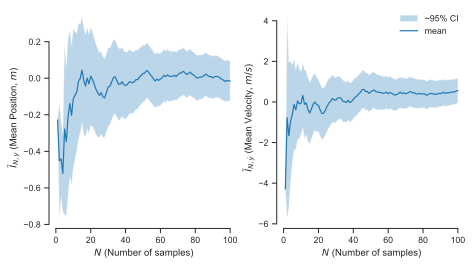

In [11]:
pos_samples_5 = pos_samples[:, -1]
vel_samples_5 = vel_samples[:, -1]
I_pos, sigma2_pos = get_mean_and_var(pos_samples_5)
I_vel, sigma2_vel = get_mean_and_var(vel_samples_5)

_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE)

axs[0].set_xlabel(N_LABEL)
axs[0].set_ylabel(MEAN_POS_LABEL)

axs[1].set_xlabel(N_LABEL)
axs[1].set_ylabel(MEAN_VEL_LABEL)

plot_confidence_at_point(axs[0], I_pos, sigma2_pos)
plot_confidence_at_point(axs[1], I_vel, sigma2_vel, legend=True)
sns.despine(trim=True)

In [12]:
def samples_required(sigma2: float, epsilon: float) -> int:
    return int(16 * sigma2 / epsilon ** 2 + 1)


def print_samples(label: str, epsilon: float, N: int):
    underline = "\033[4m"
    reset = "\033[0m"
    print(
        f"Samples required to estimate the {underline}{label}{reset} within ɛ <= {epsilon:.2f}:  {N} samples")


epsilon = 0.2
N_pos_req = samples_required(sigma2_pos[-1], epsilon)
print_samples("mean position", epsilon, N_pos_req)
N_vel_req = samples_required(sigma2_vel[-1], epsilon)
print_samples("mean velocity", epsilon, N_vel_req)

Samples required to estimate the mean position within ɛ <= 0.20:  121 samples
Samples required to estimate the mean velocity within ɛ <= 0.20:  3791 samples


### Part C

Repeat parts A and B for the squared response.
That is, do the same thing as above, but consider $y^2(t)$ and $\dot{y}^2(t)$ instead of $y(t)$ and $\dot{y}(t)$.
How many samples do you need to estimate the mean squared response at $t=5$ s with negligible epistemic uncertainty?

**Solution**:


In [13]:
pos2_samples = pos_samples ** 2
vel2_samples = vel_samples ** 2

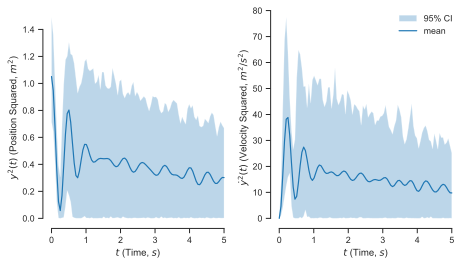

In [14]:
_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE, sharex=True)

axs[0].set_xlabel(TIME_LABEL)
axs[0].set_ylabel(POS2_LABEL)

axs[1].set_xlabel(TIME_LABEL)
axs[1].set_ylabel(VEL2_LABEL)

plot_confidence_all_time_steps(axs[0], solver.t, pos2_samples)
plot_confidence_all_time_steps(axs[1], solver.t, vel2_samples, legend=True)
sns.despine(trim=True)

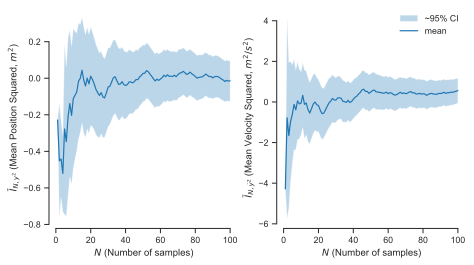

In [15]:
pos2_samples_5 = pos_samples[:, -1]
vel2_samples_5 = vel_samples[:, -1]
I_pos2, sigma2_pos2 = get_mean_and_var(pos2_samples_5)
I_vel2, sigma2_vel2 = get_mean_and_var(vel2_samples_5)

_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE)
axs[0].set_xlabel(N_LABEL)
axs[0].set_ylabel(MEAN_POS2_LABEL)

axs[1].set_xlabel(N_LABEL)
axs[1].set_ylabel(MEAN_VEL2_LABEL)

plot_confidence_at_point(axs[0], I_pos2, sigma2_pos2)
plot_confidence_at_point(axs[1], I_vel2, sigma2_vel2, legend=True)
sns.despine(trim=True)

In [16]:
N_pos2_req = samples_required(sigma2_pos2[-1], epsilon)
print_samples("mean squared position", epsilon, N_pos_req)
N_vel2_req = samples_required(sigma2_vel2[-1], epsilon)
print_samples("mean squared velocity", epsilon, N_vel_req)

Samples required to estimate the mean squared position within ɛ <= 0.20:  121 samples
Samples required to estimate the mean squared velocity within ɛ <= 0.20:  3791 samples


In [17]:
N_req = max(N_pos_req, N_pos2_req, N_vel_req, N_vel2_req)
print(f"Maximum required number of samples "
      f"from Parts A-C: {N_req} samples")

Maximum required number of samples from Parts A-C: 3791 samples


### Part D

Now that you know how many samples you need to estimate the mean of the response and the square response, use the formula:

$$
\mathbb{V}[y(t)] = \mathbb{E}[y^2(t)] - \left(\mathbb{E}[y(t)]\right)^2,
$$

and similarly, for $\dot{y}(t)$, to estimate the position and velocity variance with negligible epistemic uncertainty.
Plot both quantities as a function of time.

**Solution**:


In [18]:
samples_posterior_predictive = sample_from_solver(N_req)
pos_samples = samples_posterior_predictive[:, :, 0]
vel_samples = samples_posterior_predictive[:, :, 1]

In [19]:
E_pos = pos_samples.mean(axis=0)
V_pos = np.mean(pos_samples ** 2, axis=0) - E_pos ** 2
E_vel = vel_samples.mean(axis=0)
V_vel = np.mean(vel_samples ** 2, axis=0) - E_vel ** 2

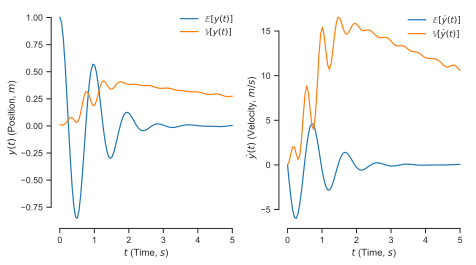

In [20]:
_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE, sharex=True)
axs[0].set_xlabel(TIME_LABEL)
axs[0].set_ylabel(POS_LABEL)

axs[1].set_xlabel(TIME_LABEL)
axs[1].set_ylabel(VEL_LABEL)

axs[0].plot(solver.t, E_pos, label=r"$\mathbb{E}[y(t)]$")
axs[0].plot(solver.t, V_pos, label=r"$\mathbb{V}[y(t)]$")
axs[0].legend(frameon=False)
axs[1].plot(solver.t, E_vel, label=r"$\mathbb{E}[\dot{y}(t)]$")
axs[1].plot(solver.t, V_vel, label=r"$\mathbb{V}[\dot{y}(t)]$")
axs[1].legend(frameon=False)
sns.despine(trim=True)

### Part E

Put together the estimated mean and variance to plot a 95\% predictive interval for the position and the velocity as functions of time.

**Hint:** You need to use the Central Limit Theorem. Check out the corresponding textbook example.

**Solution**:


In [21]:
def predictive_interval(ax: Axes, x: NDArray, E: NDArray, V: NDArray,
                        legend=False):
    N = len(x)
    I_low = E - 2.0 * np.sqrt(V / N)
    I_high = E + 2.0 * np.sqrt(V / N)
    ax.fill_between(x, I_low, I_high, alpha=0.3, label="~95% CI")
    ax.plot(x, E, label="mean")
    if legend:
        ax.legend(frameon=False)

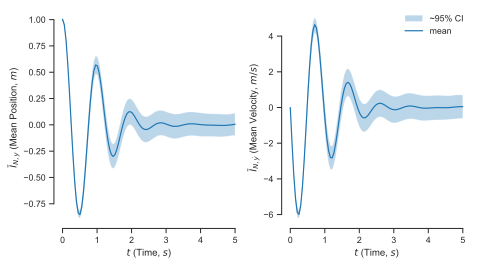

In [22]:
_, axs = plt.subplots(1, 2, figsize=DUAL_PLOT_SIZE)

axs[0].set_xlabel(TIME_LABEL)
axs[0].set_ylabel(MEAN_POS_LABEL)

axs[1].set_xlabel(TIME_LABEL)
axs[1].set_ylabel(MEAN_VEL_LABEL)

predictive_interval(axs[0], solver.t, E_pos, V_pos)
predictive_interval(axs[1], solver.t, E_vel, V_vel, legend=True)
sns.despine(trim=True)

## Problem 2 - Earthquakes again

The [San Andreas fault](https://en.wikipedia.org/wiki/San_Andreas_Fault) extends through California, forming the boundary between the Pacific and the North American tectonic plates.
It has caused some of the most significant earthquakes on Earth.
We are going to focus on Southern California, and we would like to assess the probability of a significant earthquake, defined as an earthquake of magnitude 6.5 or greater, during the next ten years.


A. The first thing we will do is review a [database of past earthquakes](https://scedc.caltech.edu/significant/chron-index.html) that have occurred in Southern California and collect the relevant data. We will start at 1900 because data before that time may be unreliable.
Go over each decade and count the occurrence of a significant earthquake (i.e., count the number of orange and red colors in each decade). We have done this for you.


In [23]:
earthquake_data = np.array(
    [
        0,  # 1900-1909
        1,  # 1910-1919
        2,  # 1920-1929
        0,  # 1930-1939
        3,  # 1940-1949
        2,  # 1950-1959
        1,  # 1960-1969
        2,  # 1970-1979
        1,  # 1980-1989
        4,  # 1990-1999
        0,  # 2000-2009
        2,  # 2010-2019
    ]
)
N = earthquake_data.shape[0]

Let's visualize them:


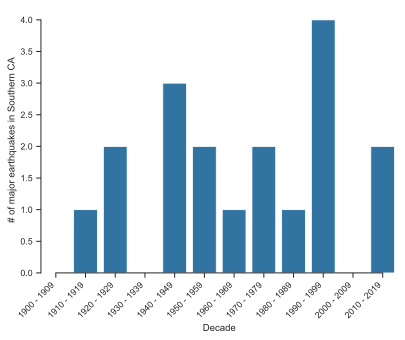

In [24]:
data = pd.DataFrame({
    "Decade": [f"{1900 + y} - {1909 + y}" for y in range(0, 10 * N, 10)],
    "# of major earthquakes in Southern CA": earthquake_data,
})
x = np.linspace(1900, 1900 + 9 * N, N, dtype=int)
sns.barplot(data=data, x="Decade", y="# of major earthquakes in Southern CA")
plt.xticks(rotation=45, horizontalalignment='right')
sns.despine(trim=True)

A. The right way to model the number of earthquakes $X_n$ in a decade $n$ is using a Poisson distribution with unknown rate parameter $\lambda$, i.e.,

$$
X_n | \lambda \sim \operatorname{Poisson}(\lambda).
$$

The probability mass function is:

$$
p(x_n|\lambda) \equiv p(X_n=x_n|\lambda) = \frac{\lambda^{x_n}}{x_n!}e^{-\lambda}.
$$

Here we have $N = 12$ observations, say $x_{1:N} = (x_1,\dots,x_N)$ (stored in `eq_data` above).
Find the _joint probability mass function_ (otherwise known as the likelihood) $p(x_{1:N}|\lambda)$ of these random variables.<br>

**Hint:** Assume that all measurements are independent. Then, their joint PMF is the product of the individual PMFs.
You should be able to simplify the expression.

<br>


**Answer:**

$$
\begin{align*}
p(x_{1:N}|\lambda) &= \prod_{i=1}^N \frac{\lambda^{x_i}}{x_i!}e^{-\lambda} \\
&= \lambda^{\sum_{i=1}^N x_i} e^{-N\lambda}\prod_{i=1}^N \frac{1}{x_i!}
\end{align*}
$$


B. The rate parameter $\lambda$ (number of significant earthquakes per ten years) is positive. What prior distribution should we assign to it if we expect it to be around 2?
A convenient choice is to pick a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution). See also [the scipy.stats page for the Gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) because it results in an analytical posterior.
We write:

$$
\lambda \sim \operatorname{Gamma}(\alpha, \beta),
$$

where $\alpha$ and $\beta$ are positive _hyper-parameters_ that we must set to represent our prior state of knowledge.
The PDF is:

$$
p(\lambda) = \frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)},
$$

where we are not conditioning on $\alpha$ and $\beta$ because they should be fixed numbers.
Use the code below to pick reasonable values for $\alpha$ and $\beta$.
<br>
**Just enter your choice of $\alpha$ and $\beta$ in the code block below.**
<br>

**Hint:** Notice that the maximum entropy distribution for a positive parameter with known expectation is the [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution), e.g., see the Table in [this wiki page](https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution). Then, notice that the Exponential is a particular case of the Gamma (set $\alpha=1$).


Mean # of earthquakes observed: 1.500
Variance of earthquakes observed: 1.417


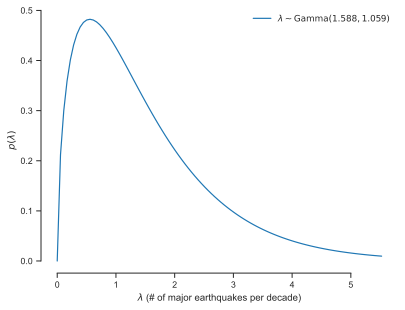

In [25]:
mean = earthquake_data.mean()
print(f"Mean # of earthquakes observed: {mean:.3f}")
variance = earthquake_data.var()
print(f"Variance of earthquakes observed: {variance:.3f}")

alpha = mean ** 2 / variance
beta = mean / variance

lambda_prior = st.gamma(alpha, scale=1.0 / beta)

# Let's plot it:
lambdas = np.linspace(0, lambda_prior.ppf(0.99), 100)
_, ax = plt.subplots()
ax.plot(lambdas,
        lambda_prior.pdf(lambdas),
        label=fr"$\lambda \sim \operatorname{{Gamma}}({alpha:.3f}, {beta:.3f})$"
        )
ax.set_xlabel(r"$\lambda$ (# of major earthquakes per decade)")
ax.set_ylabel(r"$p(\lambda)$")
ax.legend(frameon=False)
sns.despine(trim=True)

C. Show that the posterior of $\lambda$ conditioned on $x_{1:N}$ is also a Gamma, but with updated hyperparameters.
<br>
**Hint:** When you write down the posterior of $\lambda$ you can drop any multiplicative term that does not depend on it as it will be absorbed in the normalization constant. This will simplify the notation a little bit.
<br>


**Answer:**

$$
\begin{align*}
p(\lambda|x_{1:N}) &\propto p(x_{1:N}|\lambda)p(\lambda)\\
&= \lambda^{\sum_{i=1}^N x_i} e^{-N\lambda}\prod_{i=1}^N \frac{1}{x_i!} \cdot \frac{\beta^\alpha \lambda^{\alpha-1}e^{-\beta \lambda}}{\Gamma(\alpha)} \\
&= const \cdot \frac{\lambda^{(\alpha+\sum_{i=1}^N x_i)-1} e^{-(\beta + N) \lambda}}{\Gamma(\alpha)} \\
\therefore \lambda|x_{1:N} &\sim \operatorname{Gamma}(\alpha+\sum_{i=1}^N x_i, \beta + N)
\end{align*}
$$


D. Prior-likelihood pairs that result in a posterior with the same form as the prior are known as conjugate distributions. Conjugate distributions are your only hope for analytical Bayesian inference.
As a verification check, look at the Wikipedia page for [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior), locate the Poisson-Gamma pair, and verify your answer above.
<br>
_Nothing to report here. Just do it as a verification check._


E. Plot the prior and the posterior of $\lambda$ on the same plot.


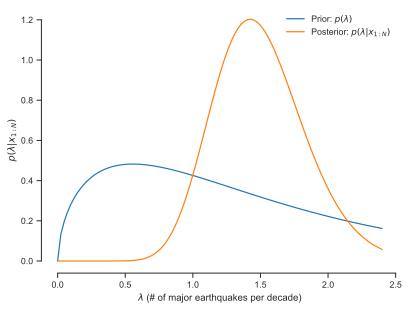

In [26]:
alpha_posterior = alpha + earthquake_data.sum()
beta_posterior = beta + N
lambda_posterior = st.gamma(alpha_posterior, scale=1.0 / beta_posterior)

# Plot it
lambdas = np.linspace(0, lambda_posterior.ppf(0.99), 100)
_, ax = plt.subplots()
ax.plot(lambdas, lambda_prior.pdf(lambdas), label=r"Prior: $p(\lambda)$")
ax.plot(
    lambdas,
    lambda_posterior.pdf(lambdas),
    label=r"Posterior: $p(\lambda|x_{1:N})$"
)
ax.set_xlabel(r"$\lambda$ (# of major earthquakes per decade)")
ax.set_ylabel(r"$p(\lambda|x_{1:N})$")
ax.legend(frameon=False)
sns.despine(trim=True)

F. Let's determine the predictive distribution for the number of significant earthquakes during the next decade.
This is something we did not do in class, but it will reappear in future lectures.
Let $X$ be the random variable corresponding to the number of significant earthquakes during the next decade.
We need to calculate:

$$
p(x|x_{1:N}) = \text{our state of knowledge about $X$ after seeing the data}.
$$

How do we do this?
We use the sum rule:

$$
p(x|x_{1:N}) = \int_{0}^\infty p(x|\lambda, x_{1:N}) p(\lambda|x_{1:N})d\lambda = \int_{0}^\infty p(x|\lambda) p(\lambda|x_{1:N})d\lambda,
$$

where going from the middle step to the rightmost one, we assumed that the number of earthquakes occurring in each decade is independent.
You can carry out this integration analytically (it gives a [negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) distribution), but we are not going to bother with it.

Below, you will write code to characterize it using Monte Carlo sampling.
You can take a sample from the posterior predictive by:

-   sampling a $\lambda$ from its posterior $p(\lambda|x_{1:N})$.
-   sampling an $x$ from the likelihood $p(x|\lambda)$.

This is the same procedure we used for replicated experiments.

Complete the code below:


In [27]:
def sample_posterior_predictive(
    N: int,
    lambda_posterior: st.rv_continuous
) -> NDArray:
    samples = np.empty(N, dtype="int")
    for i in range(N):
        lambda_sample = lambda_posterior.rvs(1)
        samples[i] = st.poisson(lambda_sample).rvs(1)[0]
    return samples

G. Plot the predictive distribution $p(x|x_{1:N})$.
<br>

**Hint:** Draw 1,000 samples using `sample_posterior_predictive` and then draw a histogram.


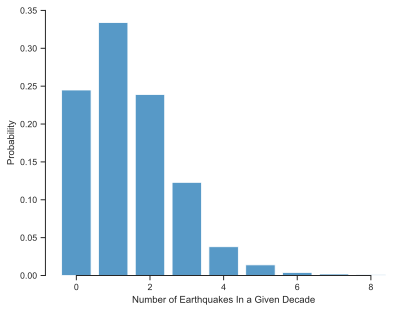

In [28]:
N = 1000
samples_posterior_predictive = sample_posterior_predictive(N, lambda_posterior)
sns.histplot(
    samples_posterior_predictive,
    discrete=True,
    stat="probability",
    shrink=0.8
)
plt.xlabel("Number of Earthquakes In a Given Decade")
sns.despine(trim=True)

H. What is the probability that at least one major earthquake will occur during the next decade?
<br>

**Hint:** You may use a Monte Carlo estimate of the probability. Ignore the uncertainty in the estimate.


In [29]:
num_samples = 10000
samples_posterior_predictive = (
    sample_posterior_predictive(num_samples, lambda_posterior)
)

prob_of_major_earthquake = sum(samples_posterior_predictive >= 1) / num_samples

print(f"p(X >= 1 | data) = {prob_of_major_earthquake}")

p(X >= 1 | data) = 0.7654


I. Find a 95\% credible interval for $\lambda$.


In [30]:
conf = 0.95
a = 1 - conf
low = lambda_posterior.ppf(a / 2)
high = lambda_posterior.ppf(1 - a / 2)
print(
    f"95% of the time, lambda should fall in "
    f"the range {low:.3f} - {high:.3f}"
)

95% of the time, lambda should fall in the range 0.911 - 2.234


J. Find the $\lambda$ that minimizes the absolute loss (see lecture), and call it $\lambda^*_N$.
Then, plot the fully Bayesian predictive $p(x|x_{1:N})$ in the same figure as $p(x|\lambda^*_N)$.


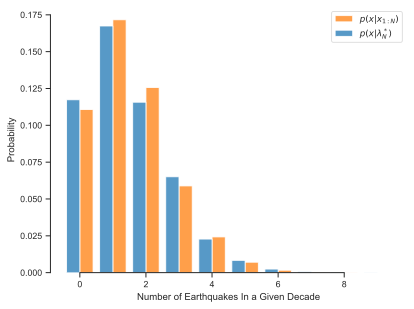

In [31]:
lambda_star_N = lambda_posterior.median()
samples_p_x_lambda_star_N = st.poisson(lambda_star_N).rvs(num_samples)
ax = plt.axes(xlabel="Number of Earthquakes In a Given Decade")
sns.histplot(
    [samples_posterior_predictive, samples_p_x_lambda_star_N],
    discrete=True,
    multiple="dodge",
    stat="probability",
    shrink=0.8,
    ax=ax,
)
plt.legend([r"$p(x|x_{1:N})$", r"$p(x|\lambda^*_N)$"])
sns.despine(trim=True)

L. Draw replicated data from the model and compare them to the observed data.

<br>

**Hint:** Complete the missing code at the places indicated below.


In [32]:
def replicate_experiment(
    posterior: st.rv_discrete, N_rep: int = 9
) -> NDArray[int]:
    N = len(earthquake_data)
    x_rep = np.empty((N_rep, N), dtype="int")
    for i in range(N_rep):
        lambda_sample = posterior.rvs()
        x_rep[i, :] = st.poisson(lambda_sample).rvs(N)
    return x_rep

Try your code here:


In [33]:
N_rep = 9
x_rep = replicate_experiment(lambda_posterior, N_rep)

If it works, then try the following visualization:


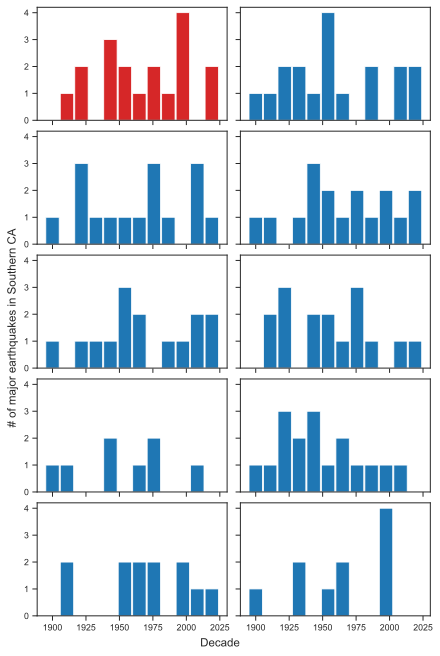

In [34]:
fig, ax = plt.subplots(5, 2, sharex="all", sharey="all", figsize=(6, 9))
fig.supxlabel("Decade")
fig.supylabel("# of major earthquakes in Southern CA")
fig.set_constrained_layout(True)
ax[0, 0].bar(np.linspace(
    1900, 2019,
    earthquake_data.shape[0]),
    earthquake_data,
    width=10,
    color="tab:red"
)
for i in range(1, N_rep + 1):
    ax[int(i / 2), i % 2].bar(
        np.linspace(1900, 2019, earthquake_data.shape[0]), x_rep[i - 1],
        width=10
    )

M. Plot the histograms and calculate the Bayesian p-values of the following test quantities:

-   Maximum number of consecutive decades with no earthquakes.
-   Maximum number of successive decades with earthquakes.

**Hint:** You may reuse the code from [Posterior Predictive Checking](posterior-predictive).


In [35]:
TestFunction = Callable[[NDArray[int | float]], int | float]


class Diagnostics:
    def __init__(
        self,
        posterior: st.rv_discrete,
        data: NDArray,
        test_func: TestFunction,
        n_rep: int = 1000,
    ):
        self.T_obs = test_func(data)
        self.N = data.shape[0]
        self.data_rep = replicate_experiment(posterior, N_rep=n_rep)
        self.T_rep = np.array(tuple(test_func(x) for x in self.data_rep))
        self.p_val = np.sum(self.T_rep > self.T_obs) / n_rep

    def plot(self):
        ax = plt.axes()
        sns.histplot(
            self.T_rep,
            discrete=True,
            stat="proportion",
            shrink=0.8,
            ax=ax
        )
        ax.vlines(
            self.T_obs,
            0,
            max(rect.get_height() for rect in ax.patches),
            color="black",
            linewidth=2
        )
        ax.legend(
            ["Observed test quantity", "Replicated test quantity"],
            loc="best"
        )


def run_diagnostics(
    posterior: st.rv_discrete,
    data: NDArray,
    test_func: TestFunction,
    n_rep: int = 1000,
):
    d = Diagnostics(posterior, data, test_func, n_rep=n_rep)
    print(f"Testing {test_func.__name__}...")
    print(f"Observed test quantity:  {d.T_obs}")
    print(f"Bayesian p_value:  {d.p_val:.4f}")
    d.plot()

Testing max_consecutive_decades_no_earthquake...
Observed test quantity:  1
Bayesian p_value:  0.4090


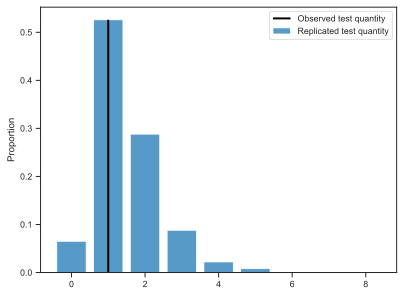

In [36]:
def max_consecutive_decades_no_earthquake(x: NDArray[int]) -> int:
    count = 0
    result = 0
    for i in range(x.shape[0]):
        if x[i] != 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result


run_diagnostics(lambda_posterior, earthquake_data,
                max_consecutive_decades_no_earthquake)

Testing max_consecutive_decades_with_earthquake...
Observed test quantity:  6
Bayesian p_value:  0.3650


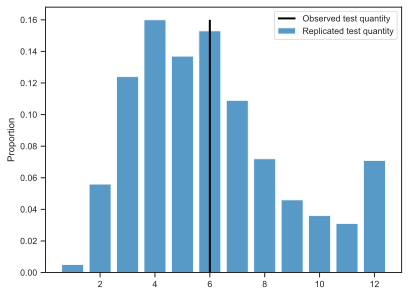

In [37]:
def max_consecutive_decades_with_earthquake(x: NDArray[int]) -> int:
    count = 0
    result = 0
    for i in range(x.shape[0]):
        if x[i] == 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result


run_diagnostics(lambda_posterior, earthquake_data,
                max_consecutive_decades_with_earthquake)